In [6]:
!pip install scipy
!pip install librosa
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 3.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 5.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 6.2 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 3.5 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.5/404.5 kB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.4/30.4 MB 3.5 MB/s eta 0:00:0000:0100:01
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23

In [18]:
import torchaudio
import torch

In [19]:
SAMPLE_WAV_SPEECH_PATH = "/Users/macbook/PycharmProjects/songsLyricsGenerator/data/DALI_v1.0/audio/wav/0a1c2a896fa34688b86547f4317a7733.wav"
SAMPLE_MP3_SPEECH_PATH = "/Users/macbook/PycharmProjects/songsLyricsGenerator/data/DALI_v1.0/audio/0a0c413b5290497c96d5327e2ef2ad8d.mp3"

In [20]:
import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa
import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]



def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'

def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=DEFAULT_LOWPASS_FILTER_WIDTH,
    rolloff=DEFAULT_ROLLOFF,
    resampling_method=DEFAULT_RESAMPLING_METHOD,
    beta=None,
    librosa_type=None,
    iters=5
):
  if method == "functional":
    begin = time.time()
    for _ in range(iters):
      F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                 rolloff=rolloff, resampling_method=resampling_method)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "transforms":
    resampler = T.Resample(sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                           rolloff=rolloff, resampling_method=resampling_method, dtype=waveform.dtype)
    begin = time.time()
    for _ in range(iters):
      resampler(waveform)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "librosa":
    waveform_np = waveform.squeeze().numpy()
    begin = time.time()
    for _ in range(iters):
      librosa.resample(waveform_np, sample_rate, resample_rate, res_type=librosa_type)
    elapsed = time.time() - begin
    return elapsed / iters

Sample Rate: 16000
Shape: (1, 3125592)
Dtype: torch.float32
 - Max:      1.000
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.241

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])



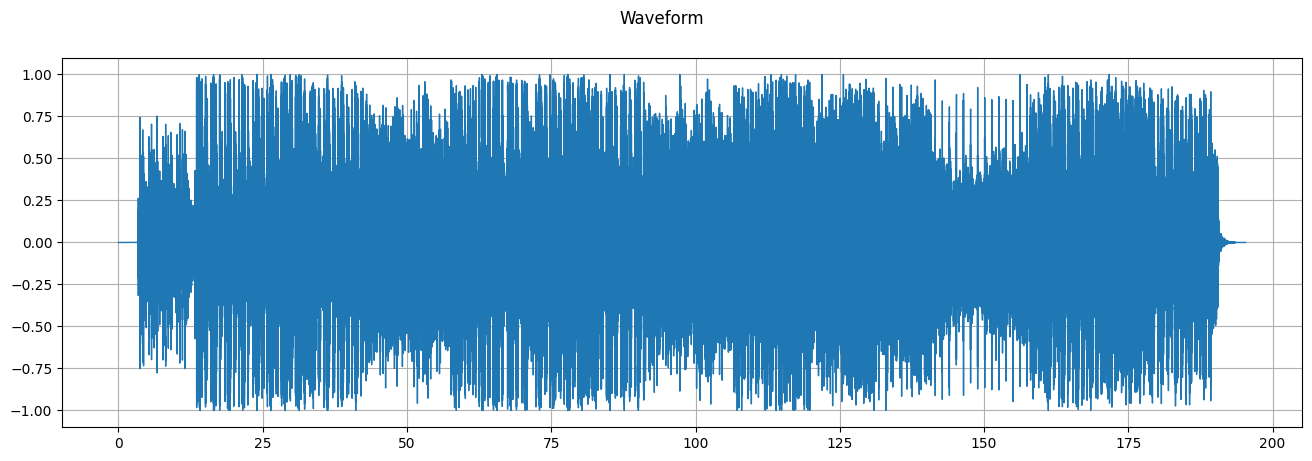

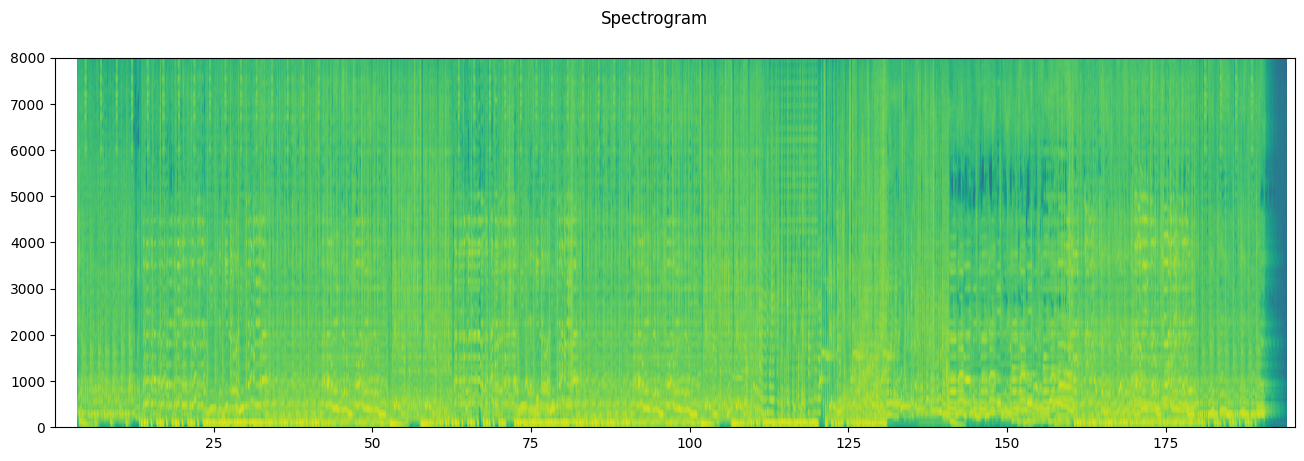

In [21]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

In [61]:
import os
import DALI as dali_code
import logging
import soundfile
from typing import Dict, Optional, List
import pandas as pd
import numpy as np

logging.basicConfig(filename='app.log', filemode='w', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)
__all__ = ["DALIDataset"]

class DALIDataset():
    def __init__(self, data_path: str , file_path: Optional[str] = None):
        self._data_path = data_path
        if file_path is None:
            self._file_path = self._data_path + 'audio/'
        else:
            self._file_path = file_path

    @property
    def data_path(self):
        logging.info("Setting the data_path")
        return self._data_path

    @data_path.setter
    def data_path(self, data_path: str):
        logging.info("Setting the data_path")
        self._data_path = data_path

    @property
    def file_path(self):
        logging.info("Setting the data_path")
        return self._file_path

    @file_path.setter
    def file_path(self, file_path: str):
        logging.info("Setting the data_path")
        self._file_path = file_path

    def get_data(self) -> Dict:
        logging.info("Getting the data_path")
        if self._data_path is not None:
            dali_dataset = dali_code.get_the_DALI_dataset(self._data_path, skip=[], keep=[])
            logging.info(f"The DALI dataset has been downloaded")
            return dali_dataset
        else:
            raise TypeError(f"Set the data_path for the location of the DALI datasets; data_path = {self._data_path}")

    def download_data(self) -> NotImplementedError:
        # dali_data = self.get_data()
        # logging.info(f"Downloading the data into the file path = {self._data_path}data/")
        raise NotImplementedError

    def get_info(self) -> pd.DataFrame:
        logging.info(f"Getting the info related to the data from the data_path = {self._data_path}")
        if self._data_path is not None:
            dali_info = dali_code.get_info(self._data_path + 'info/DALI_DATA_INFO.gz')
            dali_df = pd.DataFrame(dali_info)[1:]
            dali_df.columns = dali_info[0]
            logging.info(f"The DALI dataset has {len(dali_info)} rows in it")
            return dali_df
        else:
            raise TypeError(f"Set the data_path for the location of the DALI datasets; data_path = {self._data_path}")

    def download_info(self) -> None:
        dali_df = self.get_info()
        logging.info(f"Downloading to the file path = {self._data_path}info/ ")
        dali_df.to_csv(self._data_path + 'info/dali_info.csv')
        logging.info(f"Download complete in the file path = {self._data_path}info/ ")

    def download_audio(self) -> List:
        logging.info("Downloading audio from youtube URLs associated with the info file")
        if self._data_path is not None or self._file_path is not None:
            dali_info = self.get_info()
            logging.info(f"The DALI Audio download has {len(dali_info)} errors in it")
            return dali_code.get_audio(dali_info, self._file_path, skip=[], keep=[])
        else:
            raise TypeError(f"Set the data_path & file_path for the location of the DALI datasets; "
                            f"data_path = {self._data_path}, file_path = {self._file_path}")

    @staticmethod
    def extract_dali_id_from_directory(PATH,extension):
        wav_files = os.listdir(PATH)
        extract_dali_id = lambda x : x.split('.')[0]
        extract_file_extension = lambda x : x.split('.')[1]
        dali_ids = [extract_dali_id(file_name) for file_name \
                    in wav_files if extract_file_extension(file_name) == extension]
        return dali_ids


dali = DALIDataset(data_path="/Users/macbook/PycharmProjects/songsLyricsGenerator/data/DALI_v1.0")
dali_dataset = dali.get_data()
for k in dali_dataset["e186227bb7474fa5a7738c9108f11972"].annotations["annot"]["lines"][:5]:
    print(f"frequency = {k['freq']}, time = {k['time']}, text = {k['text']}")

frequency = [391.99543598174927, 659.2551138257398], time = [29.542, 31.2295], text = you're my world,
frequency = [391.99543598174927, 783.9908719634985], time = [33.2545, 36.7045], text = the shelter from the rain
frequency = [391.99543598174927, 659.2551138257398], time = [41.2795, 43.6795], text = you're the pills,
frequency = [349.2282314330039, 698.4564628660078], time = [44.8795, 48.4045], text = that take away my pain
frequency = [391.99543598174927, 659.2551138257398], time = [52.94199999999999, 54.742], text = you're the light,


In [23]:
from pydub import AudioSegment
newAudio = AudioSegment.from_wav("/Users/macbook/PycharmProjects/songsLyricsGenerator/data/DALI_v1.0/audio/wav/0a0c413b5290497c96d5327e2ef2ad8d.wav")
newAudio = newAudio[1000:2000]
newAudio.export('newSong.wav', format="wav") #Exports to a wav file in the current path.

<_io.BufferedRandom name='newSong.wav'>

In [25]:
import os

In [28]:
wav_files = os.listdir("/Users/macbook/PycharmProjects/songsLyricsGenerator/data/DALI_v1.0/audio/wav/")

In [30]:
wav_files[:5]

['c10fe9814d3345cbb9abaa9f8f60a060.wav',
 '3e7aaa517d9b48c9b676eac80bea5a08.wav',
 '8e3dea77362f4dd2b1d5b0a66609eba2.wav',
 '1e7af4709f35471d8b3da5e3b8047baa.wav',
 '06347d299fdd43bf86222ce8d2711c9a.wav']

In [56]:
def extract_dali_id_from_directory(PATH,extension):
  wav_files = os.listdir(PATH)
  extract_dali_id = lambda x : x.split('.')[0]
  extract_file_extension = lambda x : x.split('.')[1]
  dali_ids = [extract_dali_id(file_name) for file_name in wav_files if extract_file_extension(file_name) == extension]
  return dali_ids


In [58]:
dali_ids = extract_dali_id_from_directory("/Users/macbook/PycharmProjects/songsLyricsGenerator/data/DALI_v1.0/audio/wav/","wav")
len(dali_ids)

4533

In [ ]:
## TODO: Implement a better extraction that can smooth it rather than hard cutting the audio files at start and end.

from pydub import AudioSegment
import uuid
import csv

SOURCE_AUDIO_PATH =  "/Users/macbook/PycharmProjects/songsLyricsGenerator/data/DALI_v1.0/audio/wav/"
DESTINATION_AUDIO_PATH = "/Users/macbook/PycharmProjects/songsLyricsGenerator/data/DALI_v1.0/audio/wav_clips/"
header = ["file_name","transcription"]
audio_files = []
transcription = []
with open('/Users/macbook/PycharmProjects/songsLyricsGenerator/data/DALI_v1.0/audio/wav_clips/metadata.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(header)
    for dali_id in dali_ids:
      # print(f" ### Extracting the data for the dali_id = {dali_id} ###")
      for segment in dali_dataset[dali_id].annotations["annot"]["lines"]:
        # print(f"frequency = {segment['freq']}, time = {segment['time']}, text = {segment['text']}")
        segment_start,segment_end = segment['time']
        _transcript = segment['text']
        source_audio_file = AudioSegment.from_wav(SOURCE_AUDIO_PATH + dali_id + '.wav')
        extracted_audio_segment = source_audio_file[segment_start * 1000 :segment_end * 1000]
        extracted_audio_filename = uuid.uuid4().hex + '.wav'
        extracted_audio_segment.export(DESTINATION_AUDIO_PATH + extracted_audio_filename)
        writer.writerow([extracted_audio_filename, _transcript])
        # print(f"wav file saved at {DESTINATION_AUDIO_PATH + extracted_audio_filename} and has transcription = {_transcript}")

metadata = pd.read_csv("/Users/macbook/PycharmProjects/songsLyricsGenerator/data/DALI_v1.0/audio/wav_clips/metadata.csv")
metadata

In [ ]:
from pydub import AudioSegment
newAudio = AudioSegment.from_wav("/Users/macbook/PycharmProjects/songsLyricsGenerator/data/DALI_v1.0/audio/wav/0a0c413b5290497c96d5327e2ef2ad8d.wav")
newAudio = newAudio[1000:2000]
newAudio.export('newSong.wav', format="wav") #Exports to a wav file in the current path.